<a href="https://colab.research.google.com/github/arthurantonio/PySparkUdemy/blob/main/tarefa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspark==3.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 11.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824003 sha256=d4b35a105af75c82f817988c9566f28b5d9232fd1777057389d7073af9f22d37
  Stored in directory: /root/.cache/pip/wheels/89/d6/52/1178e354ba2207673484f0ccd7b2ded0ab6671ae5c1fc5b49a
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [16]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StringType

In [6]:
spark = (
  SparkSession.builder.appName('Tarefa')
  .config('spark.sql.repl.eagerEval.enabled', True)
  .getOrCreate()
)

In [7]:
caminho_train = '/content/drive/MyDrive/PySpark/data/Desafio/titanic/train.csv'
caminho_gender = '/content/drive/MyDrive/PySpark/data/Desafio/titanic/gender_submission.csv'

In [8]:
train = spark.read.csv(caminho_train, header=True, inferSchema=True)
gender = spark.read.csv(caminho_gender, header=True, inferSchema=True)

In [9]:
train.limit(5)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen ...",male,22.0,1,0,A/5 21171,7.25,null,S
2,1,1,"Cumings, Mrs. Joh...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. ...",female,26.0,0,0,STON/O2. 3101282,7.925,null,S
4,1,1,"Futrelle, Mrs. Ja...",female,35.0,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. Willia...",male,35.0,0,0,373450,8.05,null,S


In [10]:
gender.limit(5)

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1


O empresário quer saber se há alguma correlação entre a idade dos passageiros do Titanic e a classe em que estavam viajando. Ele gostaria de saber se os passageiros mais velhos tendiam a viajar em classes superiores ou inferiores. Como você poderia ajudá-lo a responder essa pergunta utilizando o conjunto de dados do Titanic?

In [11]:
df_pandas = train.select("Age", "Pclass").toPandas()

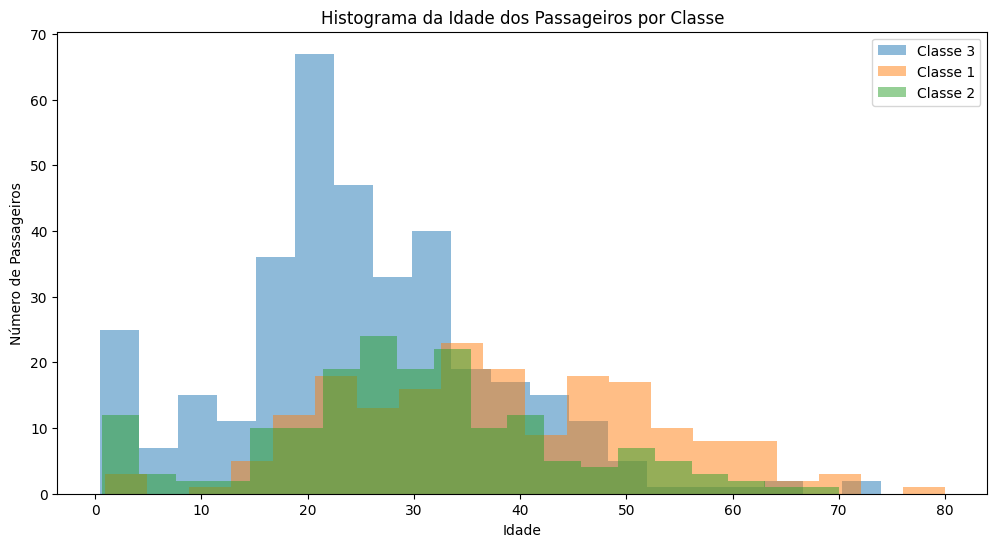

In [13]:
plt.figure(figsize=(12, 6))

for pclass in df_pandas['Pclass'].unique():
  plt.hist(df_pandas[df_pandas['Pclass'] == pclass]['Age'], bins=20, alpha=0.5, label=f'Classe {pclass}')

plt.xlabel('Idade')
plt.ylabel('Número de Passageiros')
plt.title('Histograma da Idade dos Passageiros por Classe')
plt.legend()
plt.show()


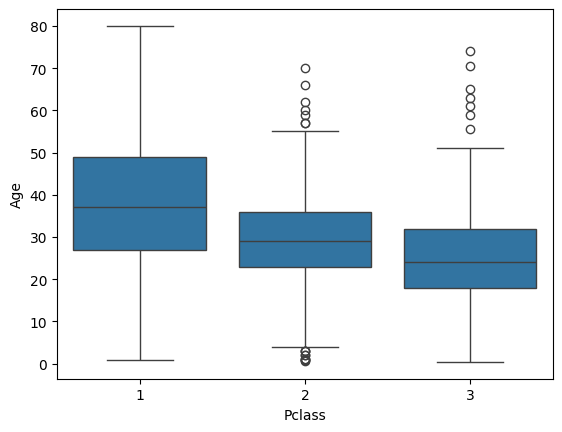

In [20]:
sns.boxplot(x='Pclass', y='Age', data=df_pandas)
plt.show()

In [27]:
# ANOVA para testar correlação
modelo = ols('Age ~ Pclass', data=df_pandas).fit()
anova_table = sm.stats.anova_lm(modelo, typ=2)

anova_table

,sum_sq,df,F,PR(>F)
Pclass,20511.429755,1.0,112.386893,1.756699e-24
Residual,129945.206190,712.0,NaN,NaN



*   Analisando inicialmente o histograma das idades, é possível observar que as classes 1 e 2 apresentam uma variância maior comparada à classe 3, a qual possui um pico entre 20 e 30 anos.
*   No Box-Plot, confirmamos o que foi observado no histograma. Na classe 1, a maior parte das idades está entre trinta e cinquenta anos, mas com limites que variam entre zero e oitenta. Já na classe 2, vemos uma amplitude um pouco menor, com uma concentração de idades entre 25 e 35 anos. Na classe 3, a idade predominante está entre 20 e 30 anos.
*   Foi realizado um teste ANOVA, cujo p-valor tende a zero, permitindo rejeitar a hipótese nula e concluir que pelo menos uma das médias de idade dos grupos é diferente das demais.

Dessa maneira, eu diria ao empresário que quanto maior a idade, maior a chance do indivíduo ser de classes superiores (1 ou 2).



---



Qual a probabilidade de sobrevivência de um passageiro de primeira classe com menos de 20 anos?



In [31]:
(
    train
    .filter((F.col('Age') < 20) & (F.col('Pclass') == 1))
    .groupBy('Survived').count()
    .withColumn('Razão', F.round(F.col('count') / F.sum('count').over(Window.partitionBy()), 2))
)

Survived,count,Razão
1,17,0.81
0,4,0.19


Dentre as pessoas com menos de vinte anos e da classe 1, vemos que a proporção de sobrevimentes é bem maior do que a de não sobreviventes



---



O empresário está interessado em criar um programa de fidelidade para seus clientes, mas não tem certeza de qual abordagem seria mais eficaz. Ele gostaria de saber se há alguma relação entre o gênero dos passageiros do Titanic e a sobrevivência no navio.

In [43]:
sexEsurvived = (
    train
    .groupBy('Sex', 'Survived').count()
)

In [50]:
sexEsurvived

Sex,Survived,count
male,0,468
female,1,233
female,0,81
male,1,109


In [52]:
sex_survived_pd = sexEsurvived.toPandas()

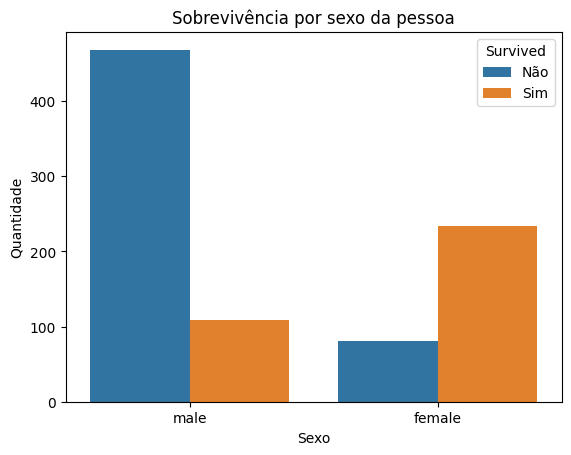

In [56]:
sns.barplot(x='Sex', y='count', hue='Survived', data=sex_survived_pd)

plt.title('Sobrevivência por sexo da pessoa')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Corrigir a legenda
legendas = {0: 'Não', 1: 'Sim'}
handles, labels = plt.gca().get_legend_handles_labels()
labels = [legendas[int(label)] for label in labels]
plt.legend(handles, labels, title='Survived')

Visualmente, é possível perceber que as mulheres (embora não eram maioria dos passageiros) tiveram mais chance de sobreviver, superando proporcionalmente e númericamente o número de sobreviventes dos homens